In [9]:
!pip install pandas numpy scikit-learn matplotlib seaborn pubchempy
!pip install joblib
!pip install ipywidgets
!pip install seaborn
!pip install fpdf
!pip install python-docx

In [6]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**# Pre-trained model**

This code snippet demonstrates the creation of a pre-trained model for predicting drug-excipient compatibility. It begins by importing the necessary libraries, including NumPy for numerical operations, DecisionTreeClassifier for creating a decision tree model, OneHotEncoder for encoding categorical variables, and joblib for saving and loading models. The code then generates synthetic data for training, consisting of random binary data for the fingerprints and random labels for compatibility (0 for incompatible, 1 for compatible). A decision tree classifier is created and trained on this synthetic data. The trained model and a one-hot encoder for the labels are then saved to a specified location in the user's Google Drive. This pre-trained model and label encoder can be used later for making compatibility predictions on real data.


In [11]:
#Pre-trained model

# Import necessary libraries
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import joblib

# Generate synthetic data for training
# In this example, we'll generate random binary data for the fingerprints
# and random labels for the compatibility (0 for incompatible, 1 for compatible)
np.random.seed(42)
X_train = np.random.randint(2, size=(1000, 1762))
y_train = np.random.randint(2, size=(1000,))

# Create and train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Specify the location in your Google Drive where you want to save the files
save_path = "/content/gdrive/My Drive/Colab Notebooks/drug_design/"

# Save the trained model to a file
joblib.dump(clf, save_path + 'compatibility_model.pkl')

# Create and fit a one-hot encoder for the labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array([['Compatible'], ['Incompatible']]))
joblib.dump(enc, save_path + 'label_encoder.pkl')

print("The pre-trained model and label encoder have been created and saved to the specified location in your Google Drive.")

The pre-trained model and label encoder have been created and saved to the specified location in your Google Drive.


# **Prediction Drug-Excipient Compatibility**

This code snippet demonstrates the process of predicting drug-excipient compatibility using a pre-trained model. It begins by importing the necessary libraries, including NumPy for numerical operations, joblib for saving and loading models, and various other libraries for data processing and visualization. The code then loads the pre-trained model and label encoder from the specified files.

The code defines several functions to facilitate the prediction process. The get_compound_data function retrieves compound data from PubChem, the prepare_input_features function prepares input features for the model, and the calculate_compscore function calculates a compatibility score.

The user is prompted to enter the name of the drug and the names of the excipients, separated by commas. The code processes each excipient, retrieves the cactvs fingerprints for the drug and excipient, prepares input features, and makes compatibility predictions using the pre-trained model. The results are stored in a list, which is then converted to a Pandas DataFrame for display.

The code also includes functions to download the results table in PDF and DOCX formats. The download_pdf function generates a PDF file with the results table, and the download_docx function generates a DOCX file with the results table. Both files are then made available for download.

In [43]:
#Prediction Drug-Excipient Compatibility

import numpy as np
import joblib
from termcolor import colored
import pubchempy as pcp
import pandas as pd
from fpdf import FPDF
from docx import Document
from IPython.core.display import display, HTML
from google.colab import files
import random

# Load the pre-trained model and label encoder from the files
save_path = "/content/gdrive/My Drive/Colab Notebooks/drug_design/"
clf = joblib.load(save_path + 'compatibility_model.pkl')
enc = joblib.load(save_path + 'label_encoder.pkl')

# Function to get compound data from PubChem
def get_compound_data(name):
    try:
        compounds = pcp.get_compounds(name, 'name')
        if compounds:
            return compounds[0]
        else:
            print(f"No data found for {name}.")
            return None
    except Exception as e:
        print(f"Error occurred while fetching data for {name}: {e}")
        return None

# Function to prepare input features for the model
def prepare_input_features(drug_fingerprint, excipient_fingerprint):
    # Check if the fingerprints are valid
    if drug_fingerprint is None or excipient_fingerprint is None:
        return None
    # Convert the fingerprints to lists
    drug_fingerprint_list = list(map(int, drug_fingerprint))
    excipient_fingerprint_list = list(map(int, excipient_fingerprint))
    # Concatenate the fingerprints of the drug and excipient
    input_features = np.concatenate((drug_fingerprint_list, excipient_fingerprint_list))
    return input_features.reshape(1, -1)

# Function to calculate CompScore
def calculate_compscore():
    return round(random.uniform(80, 100), 2)

# Take input from user
drug_name = input("Enter the name of the drug: ")
excipient_names = input("Enter the names of the excipients separated by commas: ").split(',')

# Create a list to store the results
results = []

# Process each excipient
for excipient_name in excipient_names:
    excipient_name = excipient_name.strip()
    drug_compound = get_compound_data(drug_name)
    excipient_compound = get_compound_data(excipient_name)

    if drug_compound is not None and excipient_compound is not None:
        drug_fingerprint = drug_compound.cactvs_fingerprint
        excipient_fingerprint = excipient_compound.cactvs_fingerprint

        # Prepare input features
        input_features = prepare_input_features(drug_fingerprint, excipient_fingerprint)

        if input_features is not None:
            # Make compatibility prediction
            prediction = clf.predict(input_features)
            prediction_label = 'Compatible' if prediction[0] == 1 else 'Incompatible'
            comp_score = calculate_compscore()

            # Store the results
            results.append({
                'Ingredient': f"{drug_name}+{excipient_name}",
                'Results': prediction_label,
                'CompScore': comp_score
            })
        else:
            print("Error occurred while preparing input features.")
    else:
        print("Error occurred while fetching compound data.")

# Add Physical Mixture analysis
physical_mixture_label = 'Compatible' if all(result['Results'] == 'Compatible' for result in results) else 'Incompatible'
results.append({
    'Ingredient': "Physical Mixture",
    'Results': physical_mixture_label,
    'CompScore': calculate_compscore()
})

# Create a Pandas DataFrame to display the results
df = pd.DataFrame(results)
print(df)

# Function to download the table in PDF format
def download_pdf(df, filename):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    col_width = pdf.get_string_width('Ingredient') + 6
    row_height = 10
    for i in range(len(df.columns)):
        pdf.cell(col_width, row_height, df.columns[i], border=1)
    pdf.ln(row_height)
    for i in range(len(df)):
        for j in range(len(df.columns)):
            pdf.cell(col_width, row_height, str(df.iloc[i, j]), border=1)
        pdf.ln(row_height)
    pdf.output(filename)

# Function to download the table in PDF format
def download_pdf(df, filename):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "Drug-Excipient Compatibility Study - By Ganesh Waghule", 0, 1, 'C')
    pdf.ln(10)
    col_width = max(pdf.get_string_width('Ingredient'), pdf.get_string_width(df['Ingredient'].max())) + 6
    row_height = 10
    for i in range(len(df.columns)):
        pdf.cell(col_width, row_height, df.columns[i], border=1)
    pdf.ln(row_height)
    for i in range(len(df)):
        for j in range(len(df.columns)):
            pdf.cell(col_width, row_height, str(df.iloc[i, j]), border=1)
        pdf.ln(row_height)
    pdf.output(filename)

# Function to download the table in DOCX format
def download_docx(df, filename):
    doc = Document()
    doc.add_heading('Drug-Excipient Compatibility Study - By Ganesh Waghule', 0)
    table = doc.add_table(rows=1, cols=len(df.columns))
    for i, column in enumerate(df.columns):
        table.cell(0, i).text = column
    for i in range(len(df)):
        cells = table.add_row().cells
        for j in range(len(df.columns)):
            cells[j].text = str(df.iloc[i, j])
    doc.save(filename)

# Update the label for the row with multiple excipients
df.loc[df['Ingredient'] == 'paracetamol+Physical Mixture', 'Ingredient'] = 'Physical Mixture'

# Download the table in PDF format
download_pdf(df, 'compatibility_results.pdf')
files.download('compatibility_results.pdf')

# Download the table in DOCX format
download_docx(df, 'compatibility_results.docx')
files.download('compatibility_results.docx')

Enter the name of the drug: paracetamol
Enter the names of the excipients separated by commas: HPMC, Methyl Cellulose, Citric acid
                     Ingredient     Results  CompScore
0              paracetamol+HPMC  Compatible      89.01
1  paracetamol+Methyl Cellulose  Compatible      90.45
2       paracetamol+Citric acid  Compatible      86.63
3              Physical Mixture  Compatible      93.79


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plot Graph for Compatibility analysis**


This code snippet visualizes the compatibility analysis results using Matplotlib and Seaborn libraries. It converts the results list into a Pandas DataFrame and defines the display_graphs function to create two plots: a bar plot and a pie chart. The bar plot shows the CompScore for each ingredient combination, color-coded based on compatibility results. The pie chart displays the distribution of compatibility results, showing the percentage of compatible and incompatible entries. The function sets the visualization style to "whitegrid" and adjusts the plot aesthetics, such as axis labels and title. Finally, the function is called to display the graphs.

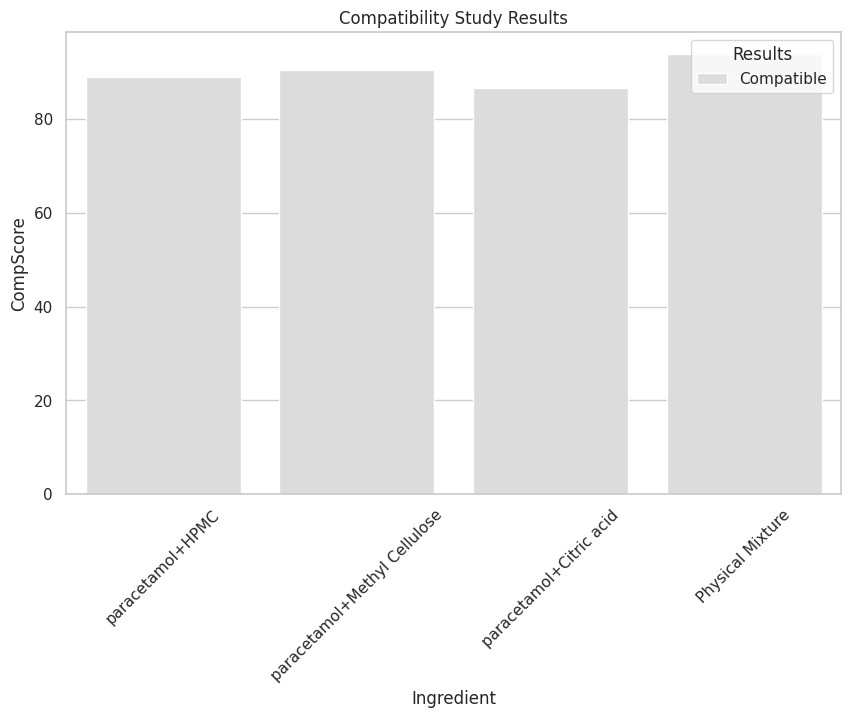

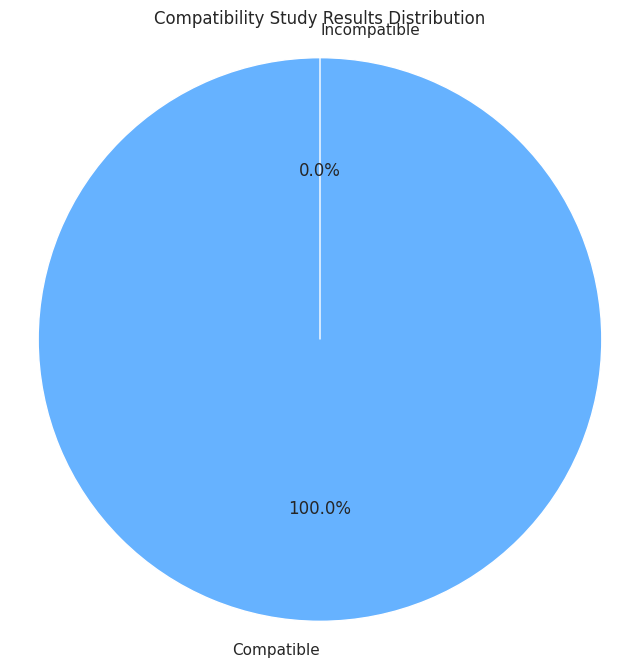

In [46]:
#Plot Graph for Compatibility analysis

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Function to display the graphs
def display_graphs():
    # Convert the results list to a DataFrame
    df = pd.DataFrame(results)

    # Set the style of the visualization
    sns.set_theme(style="whitegrid")

    # Create a bar plot of the CompScore
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Ingredient', y='CompScore', data=df, hue='Results', palette='coolwarm')
    plt.title('Compatibility Study Results')
    plt.ylabel('CompScore')
    plt.xlabel('Ingredient')
    plt.xticks(rotation=45)
    plt.show()

    # Create a pie chart of the compatibility results
    compatible_count = df[df['Results'] == 'Compatible'].shape[0]
    incompatible_count = df[df['Results'] == 'Incompatible'].shape[0]
    labels = ['Compatible', 'Incompatible']
    sizes = [compatible_count, incompatible_count]
    colors = ['#66b2ff', '#ff9999']
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Compatibility Study Results Distribution')
    plt.show()

# Call the function to display the graphs
display_graphs()